# Density-Based Clustering

Most of the traditional clustering techniques, such as k-means, hierarchical and fuzzy clustering, can be used to group data without supervision. 

However, when applied to tasks with arbitrary shape clusters, or clusters within cluster, the traditional techniques might be unable to achieve good results. That is, elements in the same cluster might not share enough similarity or the performance may be poor.
Additionally, Density-based Clustering locates regions of high density that are separated from one another by regions of low density. Density, in this context, is defined as the number of points within a specified radius.



In this section, the main focus will be manipulating the data and properties of DBSCAN and observing the resulting clustering.

In [ ]:
# Notice: For visualization of map, you need basemap package.
# if you dont have basemap install on your machine, you can use the following line to install it
!conda install -c conda-forge basemap
# Notice: you maight have to refresh your page and re-run the notebook after installation

In [2]:
import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline

<h2 id="data_generation">Data generation</h2>
The function below will generate the data points and requires these inputs:
<ul>
    <li> <b>centroidLocation</b>: Coordinates of the centroids that will generate the random data. </li>
    <ul> <li> Example: input: [[4,3], [2,-1], [-1,4]] </li> </ul>
    <li> <b>numSamples</b>: The number of data points we want generated, split over the number of centroids (# of centroids defined in centroidLocation) </li>
    <ul> <li> Example: 1500 </li> </ul>
    <li> <b>clusterDeviation</b>: The standard deviation between the clusters. The larger the number, the further the spacing. </li>
    <ul> <li> Example: 0.5 </li> </ul>
</ul>

In [3]:
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    # Create random data and store in feature matrix X and response vector y.
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, 
                                cluster_std=clusterDeviation)
    
    # Standardize features by removing the mean and scaling to unit variance
    X = StandardScaler().fit_transform(X)
    return X, y

In [4]:
X, y = createDataPoints([[4,3], [2,-1], [-1,4]] , 1500, 0.5)

## Modeling
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This technique is one of the most common clustering algorithms  which works based on density of object.
The whole idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

It works based on two parameters: Epsilon and Minimum Points  
__Epsilon__ determine a specified radius that if includes enough number of points within, we call it dense area  
__minimumSamples__ determine the minimum number of data points we want in a neighborhood to define a cluster.

In [5]:
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 0, ..., 0, 2, 0], dtype=int64)

## Distinguishing Outliers
Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.

In [6]:
# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

3

In [8]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2}

## Data visualization

In [10]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
colors

array([[0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.74771242, 0.89803922, 0.62745098, 1.        ],
       [0.36862745, 0.30980392, 0.63529412, 1.        ]])

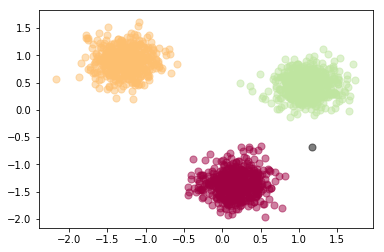

In [11]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=col, marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=col, marker=u'o', alpha=0.5)

To better underestand differences between partitional and density-based clusteitng, try to cluster the above dataset into 3 clusters using k-Means.  
Notice: do not generate data again, use the same dataset as above.

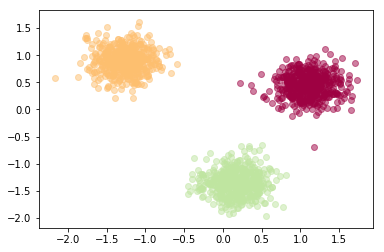

In [12]:
from sklearn.cluster import KMeans 
k = 3
k_means3 = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
k_means3.fit(X)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(k), colors):
    my_members = (k_means3.labels_ == k)
    plt.scatter(X[my_members, 0], X[my_members, 1],  c=col, marker=u'o', alpha=0.5)
plt.show()


<h1 id="weather_station_clustering" align="center"> Weather Station Clustering using DBSCAN & scikit-learn </h1>
<hr>

DBSCAN is specially very good for tasks like class identification on a spatial context. The wonderful attribute of DBSCAN algorithm is that it can find out any arbitrary shape cluster without getting affected by noise. For example, this following example cluster the location of weather stations in Canada.
<br>
DBSCAN can be used here, for instance, to find the group of stations which show the same weather condition. As you can see, it not only finds different arbitrary shaped clusters, can find the denser part of data-centered samples by ignoring less-dense areas or noises.

let's start playing with the data. We will be working according to the following workflow: </font>


### About the dataset

		
<h4 align = "center">
Environment Canada    
Monthly Values for July - 2015	
</h4>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Name in the table</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td><font color = "green"><strong>Stn_Name</font></td>
    <td><font color = "green"><strong>Station Name</font</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Lat</font></td>
    <td><font color = "green"><strong>Latitude (North+, degrees)</font></td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Long</font></td>
    <td><font color = "green"><strong>Longitude (West - , degrees)</font></td>
  </tr>
  <tr>
    <td>Prov</td>
    <td>Province</td>
  </tr>
  <tr>
    <td>Tm</td>
    <td>Mean Temperature (°C)</td>
  </tr>
  <tr>
    <td>DwTm</td>
    <td>Days without Valid Mean Temperature</td>
  </tr>
  <tr>
    <td>D</td>
    <td>Mean Temperature difference from Normal (1981-2010) (°C)</td>
  </tr>
  <tr>
    <td><font color = "black">Tx</font></td>
    <td><font color = "black">Highest Monthly Maximum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTx</td>
    <td>Days without Valid Maximum Temperature</td>
  </tr>
  <tr>
    <td><font color = "black">Tn</font></td>
    <td><font color = "black">Lowest Monthly Minimum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTn</td>
    <td>Days without Valid Minimum Temperature</td>
  </tr>
  <tr>
    <td>S</td>
    <td>Snowfall (cm)</td>
  </tr>
  <tr>
    <td>DwS</td>
    <td>Days without Valid Snowfall</td>
  </tr>
  <tr>
    <td>S%N</td>
    <td>Percent of Normal (1981-2010) Snowfall</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>P</font></td>
    <td><font color = "green"><strong>Total Precipitation (mm)</font></td>
  </tr>
  <tr>
    <td>DwP</td>
    <td>Days without Valid Precipitation</td>
  </tr>
  <tr>
    <td>P%N</td>
    <td>Percent of Normal (1981-2010) Precipitation</td>
  </tr>
  <tr>
    <td>S_G</td>
    <td>Snow on the ground at the end of the month (cm)</td>
  </tr>
  <tr>
    <td>Pd</td>
    <td>Number of days with Precipitation 1.0 mm or more</td>
  </tr>
  <tr>
    <td>BS</td>
    <td>Bright Sunshine (hours)</td>
  </tr>
  <tr>
    <td>DwBS</td>
    <td>Days without Valid Bright Sunshine</td>
  </tr>
  <tr>
    <td>BS%</td>
    <td>Percent of Normal (1981-2010) Bright Sunshine</td>
  </tr>
  <tr>
    <td>HDD</td>
    <td>Degree Days below 18 °C</td>
  </tr>
  <tr>
    <td>CDD</td>
    <td>Degree Days above 18 °C</td>
  </tr>
  <tr>
    <td>Stn_No</td>
    <td>Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).</td>
  </tr>
  <tr>
    <td>NA</td>
    <td>Not Available</td>
  </tr>


</table>

</body>
</html>

 

In [13]:
def curl(path, fname, fmodel):
    """
    curl(path, 'save as', 'wb')
    """
    import urllib.request, urllib.parse, urllib.error
    
    file = urllib.request.urlopen(path).read()
    with open(fname, fmodel) as fhand:
        fhand.write(file)

In [14]:
curl('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv', 
     'weather-stations20140101-20141231.csv', 'wb')

In [15]:
import csv
import pandas as pd
import numpy as np

filename='weather-stations20140101-20141231.csv'

pdf = pd.read_csv('weather-stations20140101-20141231.csv')
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [16]:
pdf = pdf[pd.notnull(pdf["Tm"])]
pdf = pdf.reset_index(drop=True)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


### 4-Visualization
<div id="visualization">
Visualization of stations on map using basemap package. The matplotlib basemap toolkit is a library for plotting 2D data on maps in Python. Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to a map projections. <br>

Please notice that the size of each data points represents the average of maximum temperature for each station in a year.
</div>

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm']= xs.tolist()
pdf['ym'] =ys.tolist()

#Visualization1
for index,row in pdf.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()



ModuleNotFoundError: No module named 'mpl_toolkits.basemap'